In [ ]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

--2023-05-17 13:47:34--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2023-05-17 13:47:34 (13.8 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-05-17 13:47:34--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
#tfds.disable_progress_bar()

In [ ]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [ ]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 199s 5s/step - loss: 0.0133 - accuracy: 0.9971 - val_loss: 0.0133 - val_accuracy: 0.9969
Epoch 2/10
44/44 [==============================] - 192s 4s/step - loss: 0.0118 - accuracy: 0.9971 - val_loss: 0.0123 - val_accuracy: 0.9969
Epoch 3/10
44/44 [==============================] - 194s 4s/step - loss: 0.0124 - accuracy: 0.9971 - val_loss: 0.0112 - val_accuracy: 0.9969
Epoch 4/10
44/44 [==============================] - 173s 4s/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.0106 - val_accuracy: 0.9969
Epoch 5/10
44/44 [==============================] - 196s 4s/step - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.0099 - val_accuracy: 0.9979
Epoch 6/10
44/44 [==============================] - 176s 4s/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0095 - val_accuracy: 0.9979
Epoch 7/10
44/44 [==============================] - 196s 4s/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0089 - val_accuracy: 0.9979
Epoch 8/10
44

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 31s 696ms/step - loss: 0.0069 - accuracy: 0.9986


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.006928270682692528
Test Accuracy: 0.9985632300376892


In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.013627855293452739)

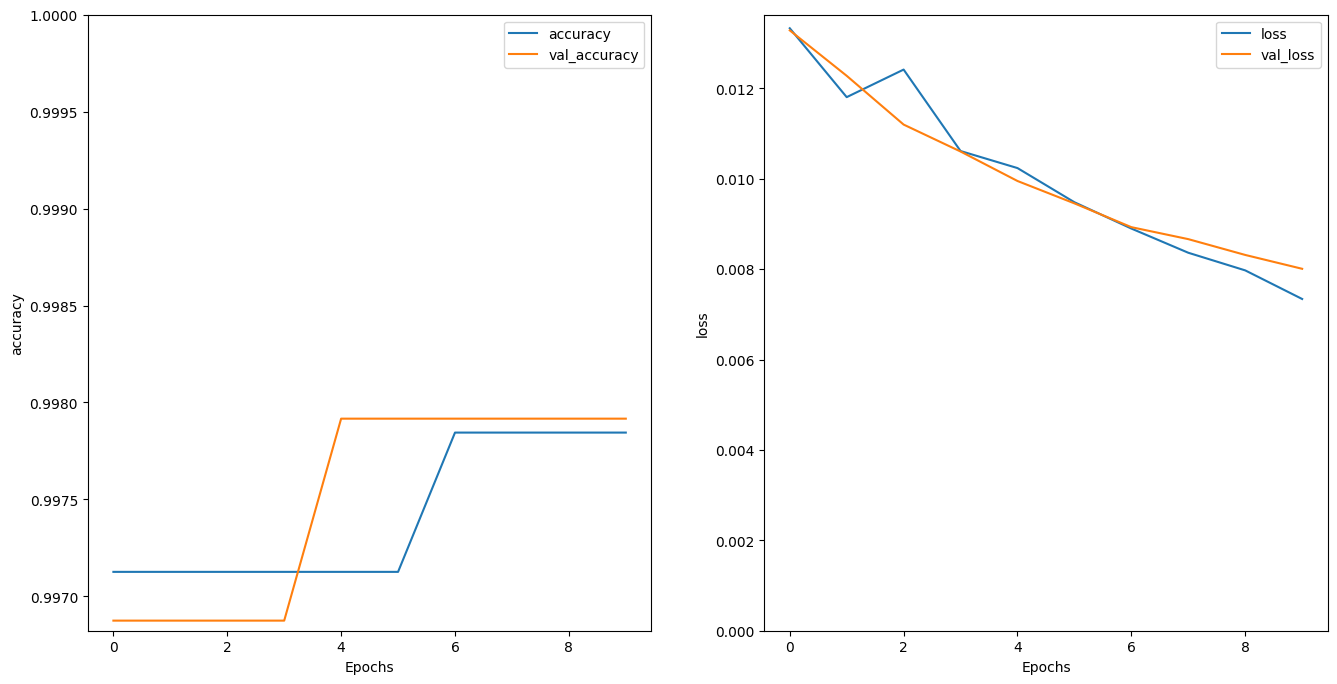

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.013328385539352894, 0.011804533191025257, 0.012414336204528809, 0.010612263344228268, 0.01023513451218605, 0.009479439817368984, 0.008897218853235245, 0.00836191326379776, 0.007971672341227531, 0.007338990457355976]
[0.013281782157719135, 0.012276350520551205, 0.01119751762598753, 0.010601676069200039, 0.00994934793561697, 0.009454268030822277, 0.008928051218390465, 0.008663059212267399, 0.008313385769724846, 0.008006945252418518]
[0.9971264600753784, 0.9971264600753784, 0.9971264600753784, 0.9971264600753784, 0.9971264600753784, 0.9971264600753784, 0.9978448152542114, 0.9978448152542114, 0.9978448152542114, 0.9978448152542114]
[0.996874988079071, 0.996874988079071, 0.996874988079071, 0.996874988079071, 0.9979166388511658, 0.9979166388511658, 0.9979166388511658, 0.9979166388511658, 0.9979166388511658, 0.9979166388511658]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 277ms/step
[[-8.923369]]
[-8.923369, 'ham']
